In [1]:
import pandas as pd
from lxml import etree
import io
import json
import matplotlib.pyplot as plt
import nltk
from nltk import ne_chunk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.chunk import conlltags2tree, tree2conlltags, RegexpParser
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from nltk.tree import Tree
import numpy as np
from wordcloud import WordCloud,STOPWORDS
import string
import re

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ricardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ricardo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ricardo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Ricardo\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Ricardo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:

def convert_to_adage_json(df):
    adage_data_model = {
        "data_source": "Australian Financial Review",
        "dataset_type": "News_Articles",
        "dataset_id": "AFR_2015",
        "time_object": {
            "timestamp": pd.Timestamp.now().isoformat(),
            "timezone": "GMT+11"
        },
        "events": []
    }
    
    for index, row in df.iterrows():
        event = {
            "time_object": {
                "timestamp": row["modified"].isoformat(),
                "duration": 0,
                "duration_unit": "second",
                "timezone": "GMT+11"
            },
            "event_type": "article",
            "attribute": {
                "guid": row["guid"],
                "byline": row["byline"],
                "headline": row["headline"],
                "section": row["section"],
                "publication_date": row["publication_date"].strftime("%Y-%m-%d"),
                "page_no": row["page_no"],
                "classifications": row["classifications"],
                "text": row.get("text")
            }
        }
        adage_data_model["events"].append(event)
    
    adage_data_model["time_object"]["timestamp"] = df["modified"].max().isoformat()
    
    return json.dumps(adage_data_model, indent=4)


xml_data = open('datasets/AFR_20150101-20150131.xml').read()

parser = etree.XMLParser(ns_clean=True)
xml = etree.parse(io.StringIO(xml_data), parser)

data = []

for dossier in xml.xpath('//dcdossier'):
    guid = dossier.get('guid')
    modified = dossier.get('modified')
    
    for doc in dossier.xpath('.//document'):
        newspaper_code = doc.xpath('.//NEWSPAPERCODE/text()')
        section = doc.xpath('.//SECTION/text()')
        story_name = doc.xpath('.//STORYNAME/text()')
        publication_date = doc.xpath('.//PUBLICATIONDATE/text()')
        newspaper = doc.xpath('.//NEWSPAPER/text()')
        page_no = doc.xpath('.//PAGENO/text()')
        byline = doc.xpath('.//BYLINE/text()')
        classifications = doc.xpath('.//CLASSIFICATION/text()')
        headline = doc.xpath('.//HEADLINE/text()')
        intro = doc.xpath('.//INTRO/text()')
        text = " ".join(doc.xpath('.//TEXT//text()'))
        
        data.append({
            'guid': guid,
            'modified': modified,
            'section': section[0].strip() if section else None,
            'publication_date': publication_date[0] if publication_date else None,
            'page_no': page_no[0].strip() if page_no else None,
            'byline': byline[0].strip() if byline else None,
            'classifications': classifications if classifications else None,
            'headline': headline[0].strip() if headline else None,
            'intro': intro[0].strip() if intro else None,
            'text': text.strip() if text else None,
        })

df = pd.DataFrame(data)
df['modified'] = pd.to_datetime(df['modified'])
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')


In [4]:
jsonData = convert_to_adage_json(df)

In [ ]:
print(jsonData)

In [6]:
def json_to_df(jsonObj):
    jsonEvent = json.loads(jsonObj)
    processed_events = []

    for event in jsonEvent['events']:
        headline = event["attribute"]["headline"]
        byline = event["attribute"]["byline"]
        text = event["attribute"]["text"]
        length = len(text.split()) if text else 0
        processed_events.append({
            "headlines": headline,
            "bylines": byline,
            "text": text,
            "length": length
        })
        
    events_df = pd.DataFrame(processed_events)
    return events_df

In [7]:
df_data = json_to_df(jsonData)

In [ ]:
df_data

count    1975.000000
mean      607.266329
std       456.158851
min         0.000000
25%       328.000000
50%       536.000000
75%       736.000000
max      5146.000000
Name: length, dtype: float64

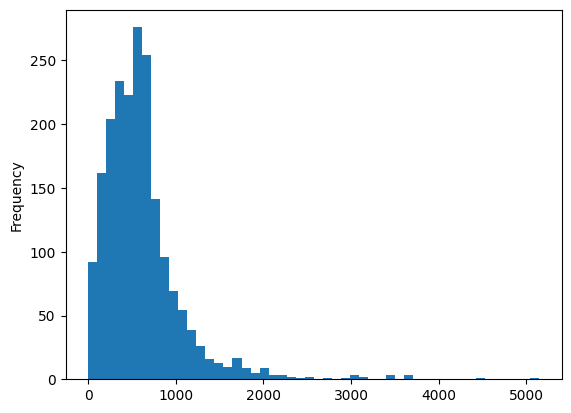

In [9]:
df_data['length'].plot.hist(bins=50)
df_data['length'].describe()

In [10]:
def clean_and_stem(txt, stopwords, punctuation_filter, symbols_filter, stemmer): 
    txt = txt.lower()
    txt = punctuation_filter.sub(' ', txt)
    txt = symbols_filter.sub('', txt)

    words = txt.split()

    filtered_words = [word for word in words if word not in stopwords]

    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    clean_stemmed_txt = ' '.join(stemmed_words)
    return clean_stemmed_txt

In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z #+_]')
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()
df_data['clean_text'] = df_data['text'].apply(lambda x: clean_and_stem(x, STOPWORDS, REPLACE_BY_SPACE_RE, BAD_SYMBOLS_RE, stemmer))

In [ ]:
df_data

In [ ]:
df_data['clean_length'] = df_data['clean_text'].apply(lambda x: len(x.split()))
df_data

In [ ]:
def clean_text_for_ner(txt, stopwords, punctuation_filter, symbols_filter):
    txt = punctuation_filter.sub(' ', txt)
    txt = symbols_filter.sub('', txt)
    words = txt.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    clean_txt = ' '.join(filtered_words)

    return clean_txt

df_data['text_for_ner'] = df_data['text'].apply(lambda x: clean_text_for_ner(x, STOPWORDS, REPLACE_BY_SPACE_RE, BAD_SYMBOLS_RE))
df_data

In [17]:
def named_entity_recognition(tagged_tokens):
    tree = ne_chunk(tagged_tokens)
    return tree

def get_continuous_chunks(text, chunk_func=named_entity_recognition):
    chunked = chunk_func(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []

    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        else:
            if current_chunk:
                named_entity = " ".join(current_chunk)
                if named_entity not in continuous_chunk:
                    continuous_chunk.append(named_entity)
                current_chunk = []

    if current_chunk:
        named_entity = " ".join(current_chunk)
        if named_entity not in continuous_chunk:
            continuous_chunk.append(named_entity)
    return continuous_chunk


In [18]:
df_data['named_entities'] = df_data['text_for_ner'].apply(get_continuous_chunks)    

In [ ]:
df_data

In [ ]:
def pos_tagging(text):
    word_tokens = word_tokenize(text)
    return pos_tag(word_tokens)

def apply_nlp_operations(events_df):
    events_df['pos_tags'] = events_df['text_for_ner'].apply(pos_tagging)
    return events_df

df_data = apply_nlp_operations(df_data)
df_data

In [ ]:
def chunking(tagged_tokens, grammar='NP: {<DT>?<JJ>*<NN>}'):
    cp = RegexpParser(grammar)
    tree = cp.parse(tagged_tokens)
    return tree

df_data['noun_phrases'] = df_data['pos_tags'].apply(lambda tags: chunking(tags, grammar='NP: {<DT>?<JJ>*<NN>}'))

df_data

In [ ]:

df_data['pos_tags']

In [ ]:
df_data['noun_phrases']

In [36]:
def tree2conll_single(n_phrase):
    iob_tagged = tree2conlltags(n_phrase)
    return iob_tagged
    

In [ ]:
df_data['extracted_chunks'] = df_data['noun_phrases'].apply(tree2conll_single)

df_data

In [ ]:
df_data['extracted_chunks'] 

In [ ]:
df_data['named_entities_str'] = df_data['named_entities'].apply(lambda x: ', '.join(map(str, x)))
df_data['named_entities_str']

In [ ]:
n_entitites_df = df_data['named_entities_str']
n_entitites_df = pd.DataFrame(n_entitites_df)

n_entities_str= n_entitites_df['named_entities_str'].str.split(",", expand = True)
n_entities_str = n_entities_str.stack().reset_index()
n_entities_str['top_n_entities'] = n_entities_str.iloc[:,-1:]
res = n_entities_str['top_n_entities']

top_N = 1000
word_dist = nltk.FreqDist(res)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['top_n_entities', 'Frequency'])

rslt.to_csv(r'names.csv')
rslt
